## MNIST 데이터에 대해 이해하고, 파이토치로 소프트맥스 회귀를 구현하기 MNIST 데이터를 분류해보자.

### 1. MNIST 데이터 이해하기

0부터 9까지의 이미지로 이루어진 손글씨 데이터셋이다.  
60,000개의 훈련 데이터와 레이블,  
총 10,000개의 테스트 데이터와 레이블로 구성되어 있다.  
레이블은 0-9까지 총 10개.  
한 이미지당 28 * 28 픽셀.

### 2. 토치비전(torchvision) 소개하기

유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함  
자연어 처리를 위해서는 토치텍스트라는 패키지가 있다.

### 3. 분류기 구현을 위한 사전 설정

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [3]:
torch.cuda.is_available()

False

In [4]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
print(f'다음 기기로 학습합니다 : {device}')

다음 기기로 학습합니다 : cpu


In [5]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [6]:
# hyperparameters
training_epochs = 15
batch_size = 100

### 4. MNIST 분류기 구현하기

torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있다.

In [7]:
#MNIST dataset

# transform= : 파이토치 텐서로 바꿔준다.
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [8]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# shuffle : 매 에포크마다 미니 배치를 셔플할 것인지 설정
# drop_last : 마지막 배치를 버릴 것인지 설정

#### drop_last를 하는 이유
1000개의 데이터, 배치 크기 128이라고 해보자.  
1000을 128로 나누면 나머지가 104가 남는다.  

데이터가 충분한 상황이라면,     
다른 미니배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여     
마지막 배치가 상대적으로 과대 평가되는 현상을 막아준다.  

---
딥러닝에서 미니 배치 크기는 모델의 성능과 학습 과정에 중요한 영향을 미칩니다.  
미니 배치 크기에 따른 주요 영향은 다음과 같습니다:

1. 학습 속도:

큰 배치 크기: 한 번에 더 많은 데이터를 처리하므로 학습 속도가 빨라집니다.  
작은 배치 크기: 더 자주 모델을 업데이트하지만, 전체적인 학습 시간이 늘어날 수 있습니다.

2. 메모리 사용:

큰 배치 크기: 더 많은 메모리를 필요로 합니다.  
작은 배치 크기: 메모리 요구량이 줄어듭니다.

3. 일반화 성능:

큰 배치 크기: 과적합 위험이 증가할 수 있습니다.  
작은 배치 크기: 데이터의 노이즈로 인해 일반화 성능이 향상될 수 있습니다.  

4. 최적화 안정성:

작은 배치 크기: 학습 과정이 불안정할 수 있지만, 지역 최솟값을 벗어나는 데 도움이 될 수 있습니다.  
큰 배치 크기: 학습이 더 안정적이지만, 지역 최솟값에 빠질 위험이 있습니다.

5. 하드웨어 효율성:

큰 배치 크기: GPU와 같은 병렬 처리 하드웨어를 더 효율적으로 활용할 수 있습니다.

---
이제 모델을 설계한다. input_dim 784, output_dim은 10이다.  
bias는 편향 b를 사용할 것인지를 나타낸다. 기본값은 True

to() 메소드는 연산을 어디서 수행할지를 정한다.  
모델의 매개변수를 지정한 장치의 메모리로 보낸다.  
GPU를 사용하려면 to('cuda')를 해 줄 필요가 있다.

In [9]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

In [10]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [11]:
# 앞서 training_epochs의 값은 15로 지정함
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X,Y in data_loader:
        # hyperparameter 설정 셀에서 ,배치 크기를 100으로 설정했으므로, 
        # 아래의 연산에서 X는 (100,784) 텐서가 된다.
        X = X.view(-1,28*28).to(device)

        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0~9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))


print('Learning finished')

Epoch: 0001 cost = 0.535150647
Epoch: 0002 cost = 0.359577775
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307107002
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074119
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526860
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422795
Learning finished


학습된 모델을 테스트 데이터로 평가하고,   
테스트 데이터에서 임의의 이미지를 선택하여 모델이 해당 이미지를 어떻게 예측하는지  
시각적으로 확인해보자.

Accuracy:  0.8883000016212463
Label:  8
Prediction:  8


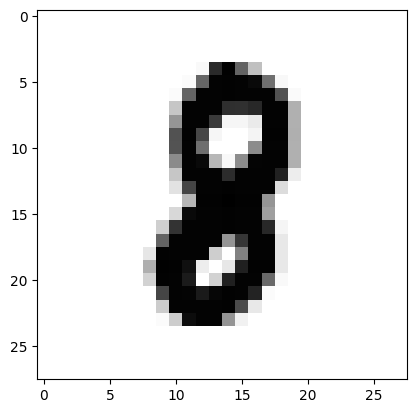

In [43]:
# 테스트 데이터를 사용하여 모델을 테스트한다.

# torch.no_grad() : gradient 계산을 수행하지 않는다.
with torch.no_grad():
    # .view(-1,28*28)은 flatten 효과를 갖는다.
    X_test = mnist_test.test_data.view(-1,28*28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, dim=1) == Y_test
    accuracy = correct_prediction.float().mean()
    print("Accuracy: ", accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다.
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r+1].view(-1,28*28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r+1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r+1].view(28,28), cmap='Greys',interpolation='nearest')
    plt.show()

.view(-1,28*28)가 flatten 효과를 갖는 이유.  
  
원본 이미지의 구조는 torch.Size([10000, 28, 28])의 구조였다.  
이를 view 메소드로 바꿔주면, torch.Size([10000,28*28])의 형태가 된다.  
즉, 2차원 행렬 10000개를 1차원 벡터 10000개로 바꿔준것이다.  
2개의 축을 가진 2차원 데이터를 1차원으로 길게 늘어뜨렸으므로, flatten  

In [33]:
print(mnist_test.test_data.shape)
print(mnist_test.test_data.view(-1,28*28).shape)

torch.Size([10000, 28, 28])
torch.Size([10000, 784])


c:\Users\user\Workspace\deeplearning-pytorch-textbook\.venv\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


.argmax 메소드는 텐서에서 가장 큰 값의 인덱스를 반환한다.  
dim을 지정하면, 행방향, 혹은 열방향으로 가장 큰 값을 찾아준다.  
prediction의 경우 torch.Size([10000,10])이다.  
10000개의 이미지에 대한, 10개의 클래스에 대한 예측값이 있다.  
즉, 행방향(dim=1)로 가장 큰 값의 인덱스를 모두 반환해준다.  

In [31]:
print(prediction[0])
print(torch.argmax(prediction[0]))

tensor([  218.3591, -2471.1321,   346.5565,  1417.3794,  -767.6719,  -352.6882,
        -2070.1768,  2475.0425,   393.8430,   791.0422])
tensor(7)


Y_test는 실제 정답 레이블을 담고 있는 원-핫 벡터이다.

In [38]:
print(Y_test[0])
print(mnist_test.test_labels)
print(mnist_test.test_labels.shape)

tensor(7)
tensor([7, 2, 1,  ..., 4, 5, 6])
torch.Size([10000])


correct_prediction은 정답을 맞추었는지 틀렸는지 담고 있는 텐서이다.  
해당 텐서의 shape는 다음과 같다.

In [39]:
correct_prediction.shape

torch.Size([10000])

마찬가지로 flatten

In [48]:
print(mnist_test.test_data[r:r+1].shape)
print(mnist_test.test_data[r:r+1].view(-1,28*28).shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


c:\Users\user\Workspace\deeplearning-pytorch-textbook\.venv\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


.item() 메소드는 다음과 같이 python number로 return해준다.
Returns the value of this tensor as a standard Python number. 

In [45]:
print(Y_single_data)
print(Y_single_data.item())

tensor([8])
8
